In [ ]:
import os
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pickle
%matplotlib inline


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
df = pd.read_csv("Crop_recommendation.csv")
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
#unique classes of plants
df["label"].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

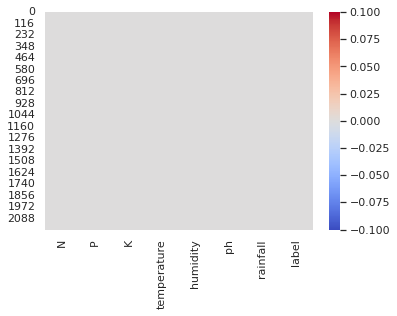

In [ ]:
#heatmap to check null/missing values
sns.heatmap(df.isnull(), cmap = "coolwarm")
plt.show()

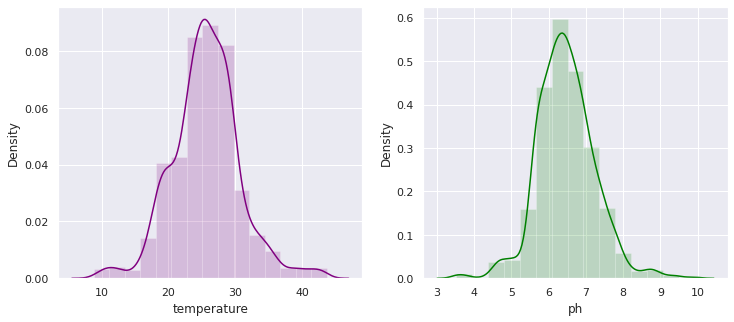

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)

sns.distplot(df["temperature"], bins = 15, color = "purple", hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})
#so from graph it seems like both have normal distribution

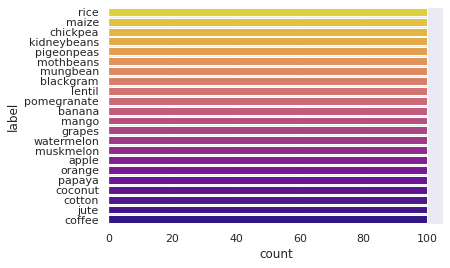

In [ ]:
sns.countplot(y='label',data=df, palette="plasma_r")

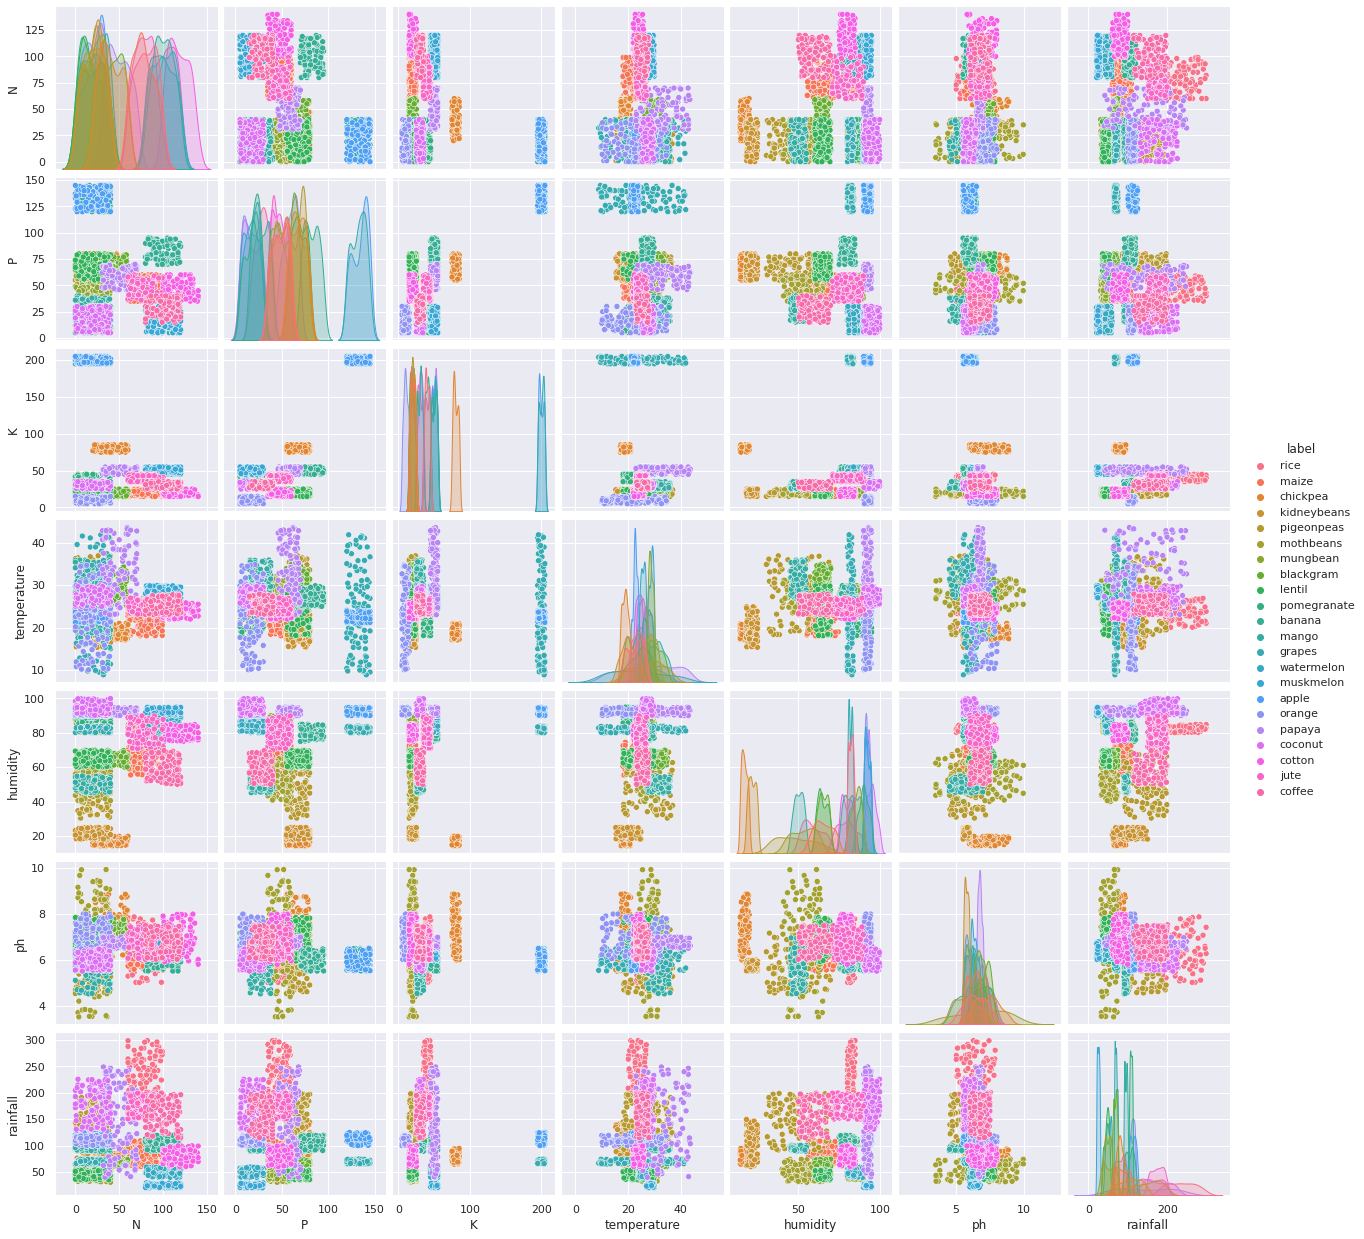

In [ ]:
#distplot to see correlation between two variables
sns.pairplot(df, hue = 'label')

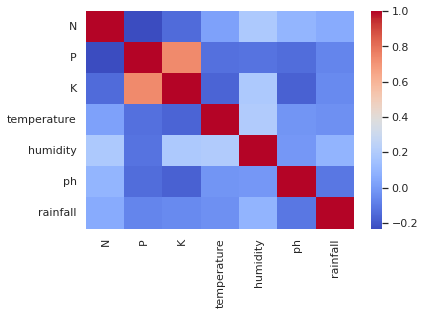

In [ ]:
sns.heatmap(df.corr(), cmap = "coolwarm")

In [ ]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

c.cat.categories

Index(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
       'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango',
       'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas',
       'pomegranate', 'rice', 'watermelon'],
      dtype='object')

In [ ]:
y = df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

In [ ]:
#saving the scaler for future scaling during deployment
pickle.dump(scaler, open("crop_recommendation_scaler.pkl", "wb"))

In [ ]:
#modelling part using sklearn library

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9781818181818182

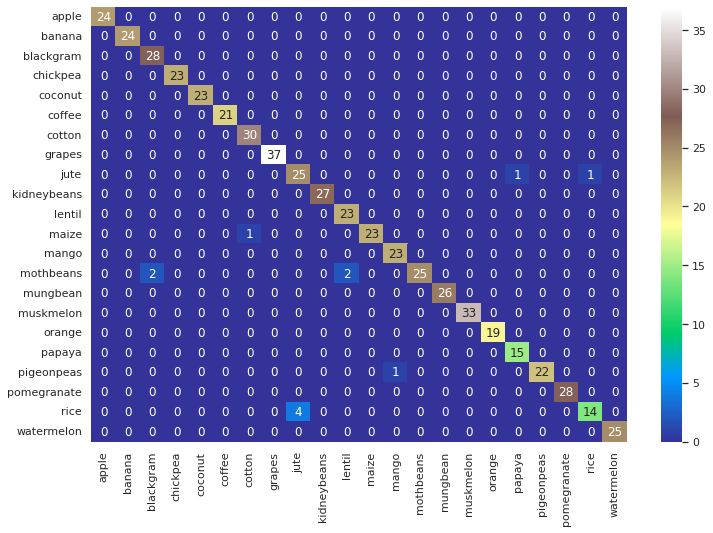

In [ ]:
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

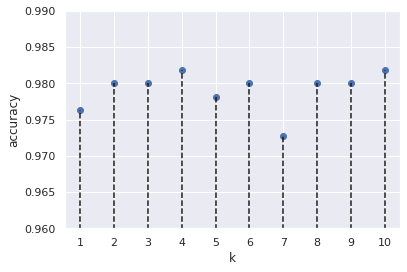

In [ ]:
#selecting best k
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

#from graph best k value is 4 or 10

In [ ]:
#classification using SVM classifier
svc_linear = SVC(kernel = "linear").fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy: ",svc_linear.score(X_test_scaled,y_test))

svc_rbf = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy: ", svc_rbf.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

Linear Kernel Accuracy:  0.9745454545454545
Rbf Kernel Accuracy:  0.9872727272727273
Poly Kernel Accuracy:  0.9890909090909091


In [ ]:
#parameter tuning for svm model
parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist(), 'kernel' : ["rbf", "poly"]}
model = GridSearchCV(estimator = SVC(), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'kernel': ['rbf', 'poly']})

In [ ]:
print(model.best_score_ )
print(model.best_params_ )

0.9915180775288559
{'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train_scaled, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))

RF Accuracy on training set: 0.97
RF Accuracy on test set: 0.97


In [ ]:
print(classification_report(y_test, clf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       0.78      1.00      0.88        28
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        37
           8       0.92      0.89      0.91        27
           9       1.00      1.00      1.00        27
          10       0.92      1.00      0.96        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        23
          13       1.00      0.66      0.79        29
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00        33
          16       1.00      1.00      1.00        19
          17       1.00    

In [ ]:
#lastly checking with xgboost model
#also using gridsearch cv for finding best parameters

parameters = {'max_depth' : [4, 5, 6], 'learning_rate' : [0.01, 0.1, 1], 'n_estimators' : [10, 100, 1000]}
model = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [10, 100, 1000]})

In [ ]:
print(model.best_score_ )
print(model.best_params_ )

0.988479689226357
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1000}


In [ ]:
#so from all this model we can say that svm model with rbf kernel is giving us the best accuracy so using it as our final model

In [ ]:
#training the SVM model on all the available data
X_scaled = scaler.transform(X)
#{'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
svm_model = SVC(C = 10, gamma = 10, kernel = 'rbf')
svm_model.fit(X_scaled , y)
svm_model.score(X_scaled, y)

0.9959090909090909

In [ ]:
pickle.dump(svm_model, open("crop_recommendation_svm.pkl", "wb"))